#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.
    * 성능 가이드
            * Accuracy : 0.980~1.00


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 1) 로컬 수행(Ananconda)
            * 제공된 압축파일을 다운받아 압축을 풀고
            * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
        * 2) 구글콜랩
            * 구글 드라이브 바로 밑에 project 폴더를 만들고,
            * 데이터 파일을 복사해 넣습니다.
    
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [ ]:
#path = 'C:/Users/User/Desktop/'

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/project(mini3)/lable/'

### (2) 라이브러리 불러오기

#### 1) 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import *

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

#### 2) 제공 함수 생성
* 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
* 입력 :
    * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
    * names : 변수 이름 목록(예 : x_train.columns
    * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
    * topn : 중요도 상위 n개만 표시. all 이면 전체.
* 출력 :
    * 중요도 그래프 : 중요도 내림차순으로 정렬
    * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
file1 = 'data01_train.csv'
file2 = 'data01_test.csv'
file3 = 'features.csv'

In [6]:
data = pd.read_csv(path + file1)
test = pd.read_csv(path + file2)
features = pd.read_csv(path + file3)

In [7]:
# 불필요한 칼럼 삭제
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

In [8]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [9]:
result_pkl = joblib.load('/content/drive/MyDrive/project(mini3)/lable/fi_analysis.pkl')
data_pkl = pd.DataFrame(result_pkl)

In [10]:
data_pkl.head()

,sensor,agg,axis,feature_name,fi_all,fi_dynamic,fi_standing,fi_sitting,fi_laying,fi_walking,fi_walking_up,fi_walking_down
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000283,0.000039,0.000216,0.000607,0.000100,0.000240,0.000211,0.000086
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000493,0.000022,0.000368,0.001047,0.000127,0.000063,0.000544,0.000081
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000214,0.000020,0.000187,0.000538,0.000192,0.000139,0.000329,0.000101
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.009159,0.000000,0.005158,0.000307,0.001291,0.008580,0.008909,0.035496
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000306,0.000000,0.000333,0.000107,0.000090,0.000268,0.000314,0.001286


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [11]:
data['Activity_dynamic'] = data['Activity'].map({'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1,
                                     'LAYING':0, 'STANDING':0,'SITTING':0})

In [12]:
data[['Activity','Activity_dynamic']].head()

,Activity,Activity_dynamic
0,STANDING,0
1,LAYING,0
2,STANDING,0
3,WALKING,1
4,WALKING_DOWNSTAIRS,1


In [13]:
x = data.drop(['Activity_dynamic',  'Activity'], axis = 1)
y1 = data.loc[:, 'Activity']
y2 = data.loc[:, 'Activity_dynamic']

x_train, x_val, y1_train, y1_val = train_test_split(x, y1, test_size = .2, random_state = 777)
x_train, x_val, y2_train, y2_val = train_test_split(x, y2, test_size = .2, random_state = 777)

In [15]:
y1.value_counts()

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) Logistic Regression

In [16]:
lr_model = LogisticRegression()
lr_model.fit(x_train, y2_train)
lr_pred = lr_model.predict(x_val)
print('accuracy :',accuracy_score(y2_val, lr_pred))
print('='*60)
print(confusion_matrix(y2_val, lr_pred))
print('='*60)
print(classification_report(y2_val, lr_pred))

accuracy : 0.9988674971687429
[[509   1]
 [  0 373]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       510
           1       1.00      1.00      1.00       373

    accuracy                           1.00       883
   macro avg       1.00      1.00      1.00       883
weighted avg       1.00      1.00      1.00       883



In [17]:
# lr_model_s = LogisticRegression()
# lr_model_s.fit(x_train_s, y2_train_s)
# lr_pred_s = lr_model_s.predict(x_val_s)
# lr_accuracy = accuracy_score(y2_val_s, lr_pred_s)
# print('accuracy :',accuracy_score(y2_val_s, lr_pred_s))
# print('='*60)
# print(confusion_matrix(y2_val_s, lr_pred_s))
# print('='*60)
# print(classification_report(y2_val_s, lr_pred_s))

accuracy : 0.9988674971687429
[[509   1]
 [  0 373]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       510
           1       1.00      1.00      1.00       373

    accuracy                           1.00       883
   macro avg       1.00      1.00      1.00       883
weighted avg       1.00      1.00      1.00       883



#### 2) RandomForest

In [48]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y2_train)
rf_pred = rf_model.predict(x_val)
print('accuracy :',accuracy_score(y2_val, rf_pred))
print('='*60)
print(confusion_matrix(y2_val, rf_pred))
print('='*60)
print(classification_report(y2_val, rf_pred))

accuracy : 0.9991503823279524
[[667   1]
 [  0 509]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       668
           1       1.00      1.00      1.00       509

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [29]:
# rf_model_s = RandomForestClassifier()
# rf_model_s.fit(x_train_s, y2_train_s)
# rf_pred = rf_model_s.predict(x_val_s)
# rf_accuracy = accuracy_score(y2_val_s, rf_pred)
# print('accuracy :',accuracy_score(y2_val_s, rf_pred))
# print('='*60)
# print(confusion_matrix(y2_val_s, rf_pred))
# print('='*60)
# print(classification_report(y2_val_s, rf_pred))

accuracy : 0.9988674971687429
[[509   1]
 [  0 373]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       510
           1       1.00      1.00      1.00       373

    accuracy                           1.00       883
   macro avg       1.00      1.00      1.00       883
weighted avg       1.00      1.00      1.00       883



In [41]:
# x = data.drop(['Activity', 'Activity_dynamic'], axis=1)
# y = data['Activity_dynamic']
# scaler = MinMaxScaler()
# x_s = scaler.fit_transform(x)
# x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_s, y, test_size = .15, random_state = 777)

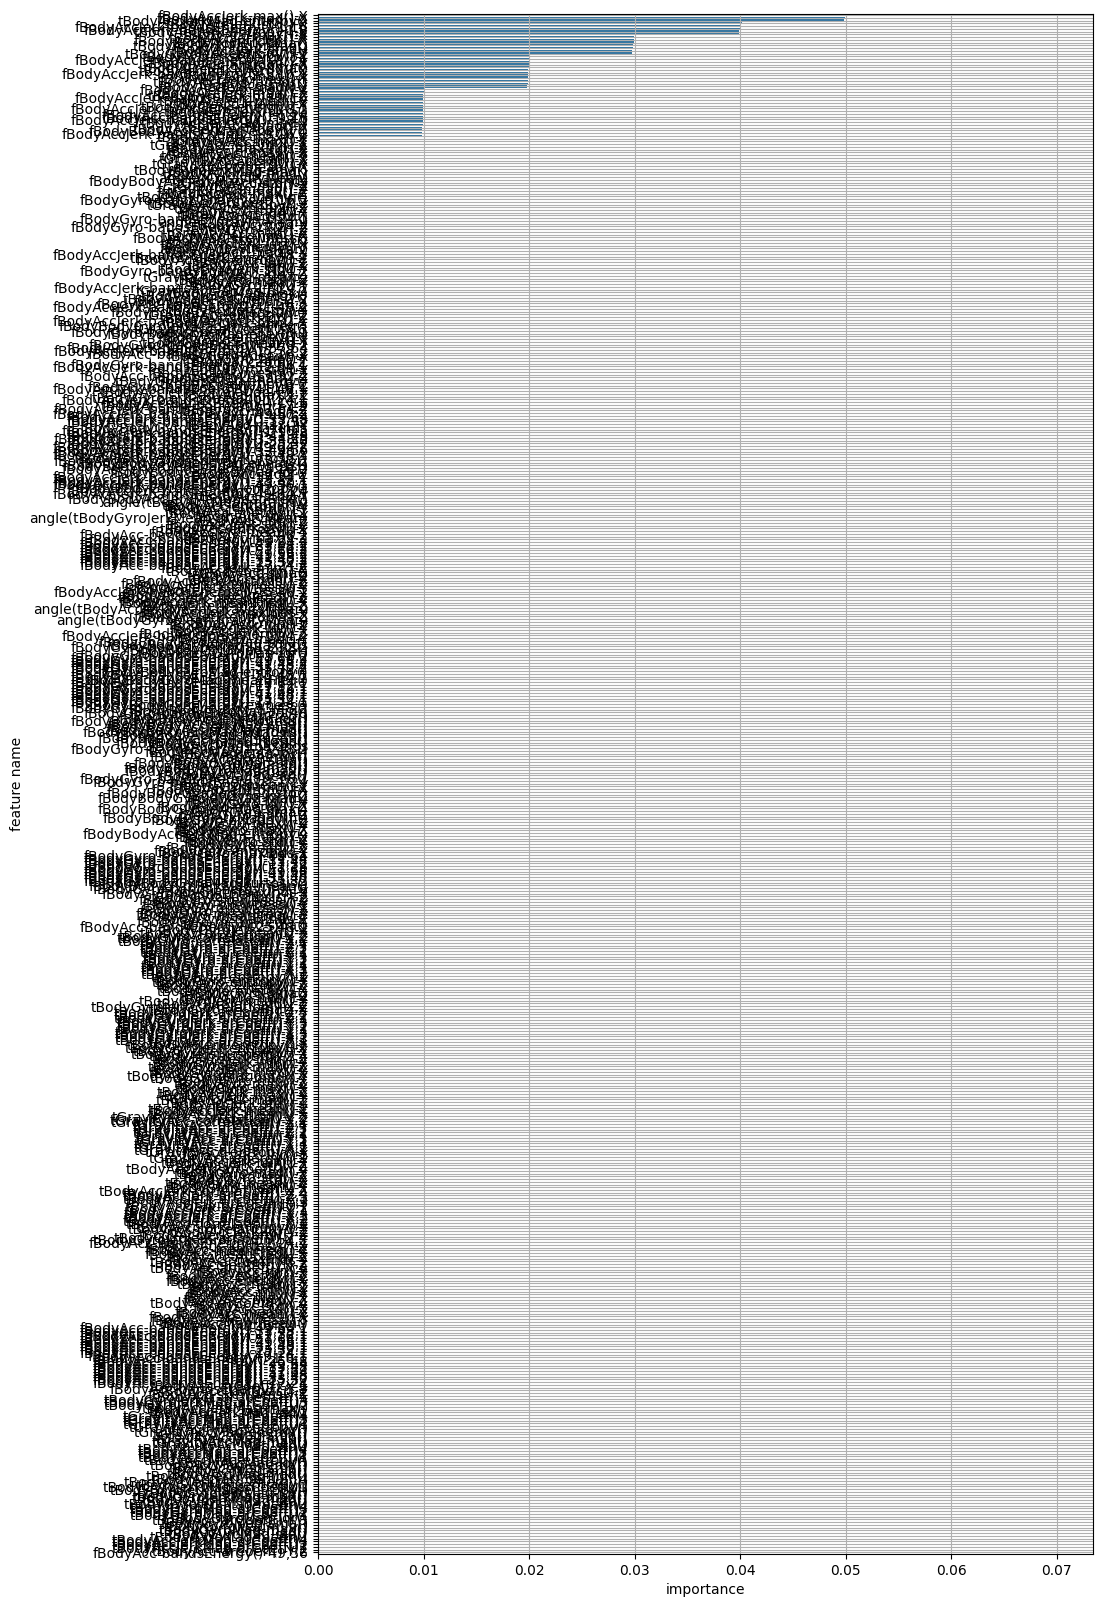

In [46]:
r = plot_feature_importance(rf_model_s.feature_importances_, list(x_train), False)

In [60]:
# r = r[r['feature_importance'] != 0]

In [62]:
# r.count()

feature_name          143
feature_importance    143
dtype: int64

In [ ]:
# acc = []

# for i in range(100) :
#     featureN = r.loc[:i, 'feature_name']
#     x_trainN = x_train[featureN]
#     x_valN = x_val[featureN]
#     m = RandomForestClassifier()
#     m.fit(x_trainN, y2_train)
#     p = m.predict(x_valN)
#     acc.append(accuracy_score(y2_val, p))
#     print(i)

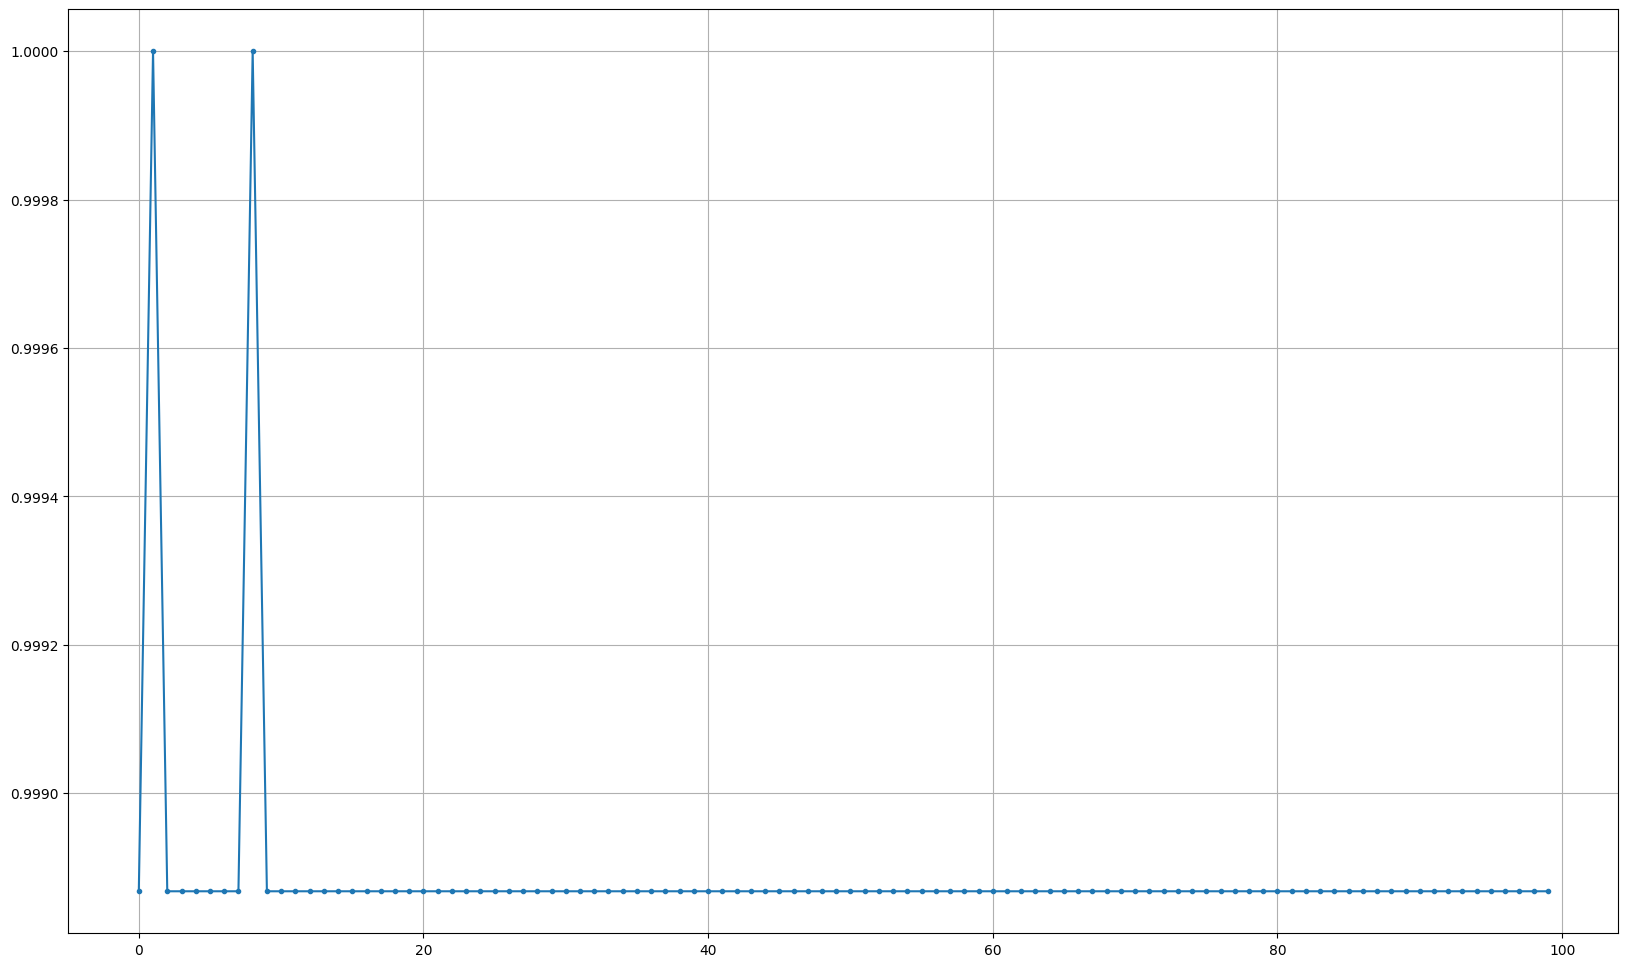

In [56]:
# plt.figure(figsize = (20,12))
# plt.plot(range(100), acc, marker = '.')
# #plt.xlim(0,10)
# plt.grid()
# plt.show()

#### 3) k-Nearst Neighbors

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(x_train, y2_train)
knn_pred = knn_model.predict(x_val)
print('accuracy :',accuracy_score(y2_val, knn_pred))
print('='*60)
print(confusion_matrix(y2_val, knn_pred))
print('='*60)
print(classification_report(y2_val, knn_pred))

accuracy : 0.9988674971687429
[[509   1]
 [  0 373]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       510
           1       1.00      1.00      1.00       373

    accuracy                           1.00       883
   macro avg       1.00      1.00      1.00       883
weighted avg       1.00      1.00      1.00       883



In [ ]:
# knn_model_s = KNeighborsClassifier(n_neighbors=10)
# knn_model_s.fit(x_train_s, y2_train_s)
# knn_pred_s = knn_model_s.predict(x_val_s)
# knn_accuracy = accuracy_score(y2_val_s, knn_pred_s)
# print('accuracy :',accuracy_score(y2_val_s, knn_pred_s))
# print('='*60)
# print(confusion_matrix(y2_val_s, knn_pred_s))
# print('='*60)
# print(classification_report(y2_val_s, knn_pred_s))

accuracy : 0.9988674971687429
[[509   1]
 [  0 373]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       510
           1       1.00      1.00      1.00       373

    accuracy                           1.00       883
   macro avg       1.00      1.00      1.00       883
weighted avg       1.00      1.00      1.00       883



#### 4) Support Vector Machine(SVM)

##### 1) kernel = 'rbf'

In [32]:
svc_r_modle = SVC(C=1, gamma=0.01, kernel = 'rbf', random_state=777)
svc_r_modle.fit(x_train, y2_train)
svc_r_pred = svc_r_modle.predict(x_val)
svc_r_accuracy = accuracy_score(y2_val, svc_r_pred)
print('accuracy :',accuracy_score(y2_val, svc_r_pred))
print('='*60)
print(confusion_matrix(y2_val, svc_r_pred))
print('='*60)
print(classification_report(y2_val, svc_r_pred))

accuracy : 0.9991503823279524
[[667   1]
 [  0 509]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       668
           1       1.00      1.00      1.00       509

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



##### 1) kernel = 'linear'

In [25]:
svc_l_model = SVC(C=1, gamma=0.01, kernel = 'linear', random_state=777)
svc_l_model.fit(x_train, y2_train)
svc_l_pred = svc_l_model.predict(x_val)
svc_l_accuracy = accuracy_score(y2_val, svc_l_pred)
print('accuracy :',accuracy_score(y2_val, svc_l_pred))
print('='*60)
print(confusion_matrix(y2_val, svc_l_pred))
print('='*60)
print(classification_report(y2_val, svc_l_pred))

accuracy : 0.9991503823279524
[[667   1]
 [  0 509]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       668
           1       1.00      1.00      1.00       509

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [67]:
# # 딕셔너리 형태로 관심있는 매개변수의 그리드 설정하기
# param_grid = {'C': [0.01, 1, 100],
#              'gamma': [0.0001, 0.001, 0.1, 1],
#               'kernel': ['linear', 'rbf'] }

# #생성
# # refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재학습시킴.
# model_svc = SVC()
# m3_3= GridSearchCV (model_svc, param_grid, return_train_score=True) #cross-validation 옵션 추가? cv=5

# #학습
# # train data로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가 .
# m3_3.fit(x_train_s, y2_train_s)

# #결과
# # GridSearchCV 결과 추출하여 DataFrame으로 변환
# scores_df = pd.DataFrame(m3_3.cv_results_)

최적파라미터: {C: 1, gamma: 0.1, kernel: rbf}
최고성능: 1.0


#### 모델 별 정확도 비교

In [ ]:
print('Logistic Regression accuracy :', lr_accuracy)
print('RandamForest accuracy :', rf_accuracy)
print('k-Nearst Neighbors  accuracy :', knn_accuracy)
print('SVM(rbf) accuracy :', svc_r_accuracy)
print('SVM(linear) accuracy :', svc_l_accuracy)

Logistic Regression accuracy : 0.9988674971687429
RandamForest accuracy : 0.9988674971687429
k-Nearst Neighbors  accuracy : 0.9988674971687429
SVM(rbf) accuracy : 0.9988674971687429
SVM(linear) accuracy : 0.9988674971687429


### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [15]:
x_train2_0 = x_train[y2_train == 0]
y_train2_0 = y1_train[y2_train == 0]

x_val2_0 = x_val[y2_val == 0]
y_val2_0 = y1_val[y2_val == 0]

In [16]:
lr_model_0 = LogisticRegression()
lr_model_0.fit(x_train2_0, y_train2_0)
pred2_0 = lr_model_0.predict(x_val2_0)
lr_accuracy_0 = accuracy_score(y_val2_0, pred2_0)
print('accuracy :',accuracy_score(y_val2_0, pred2_0))
print('='*60)
print(confusion_matrix(y_val2_0, pred2_0))
print('='*60)
print(classification_report(y_val2_0, pred2_0))

accuracy : 0.9745508982035929
[[239   0   0]
 [  0 208  10]
 [  0   7 204]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       239
     SITTING       0.97      0.95      0.96       218
    STANDING       0.95      0.97      0.96       211

    accuracy                           0.97       668
   macro avg       0.97      0.97      0.97       668
weighted avg       0.97      0.97      0.97       668



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
rf_model_0 = LogisticRegression()
rf_model_0.fit(x_train2_0, y_train2_0)
rf_pred = rf_model_0.predict(x_val2_0)
rf_accuracy_0 = accuracy_score(y_val2_0, rf_pred)
print('accuracy :',accuracy_score(y_val2_0, rf_pred))
print('='*60)
print(confusion_matrix(y_val2_0, rf_pred))
print('='*60)
print(classification_report(y_val2_0, rf_pred))

accuracy : 0.9745508982035929
[[239   0   0]
 [  0 208  10]
 [  0   7 204]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       239
     SITTING       0.97      0.95      0.96       218
    STANDING       0.95      0.97      0.96       211

    accuracy                           0.97       668
   macro avg       0.97      0.97      0.97       668
weighted avg       0.97      0.97      0.97       668



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
knn_model_0 = KNeighborsClassifier(n_neighbors=6)
knn_model_0.fit(x_train_s, y_train_s)
knn_pred = knn_model_0.predict(x_val_s)
knn_accuracy_0 = accuracy_score(y_val_s, knn_pred)
print('accuracy :',accuracy_score(y_val_s, knn_pred))
print('='*60)
print(confusion_matrix(y_val_s, knn_pred))
print('='*60)
print(classification_report(y_val_s, knn_pred))

accuracy : 0.9526748971193416
[[177   0   0]
 [  1 131  12]
 [  0  10 155]]
              precision    recall  f1-score   support

      LAYING       0.99      1.00      1.00       177
     SITTING       0.93      0.91      0.92       144
    STANDING       0.93      0.94      0.93       165

    accuracy                           0.95       486
   macro avg       0.95      0.95      0.95       486
weighted avg       0.95      0.95      0.95       486



In [19]:
svc_r_modle_0 = SVC(C=1, gamma=0.01, kernel = 'rbf', random_state=777)
svc_r_modle_0.fit(x_train2_0, y_train2_0)
svc_r_pred = svc_r_modle_0.predict(x_val2_0)
svc_r_accuracy_0 = accuracy_score(y_val2_0, svc_r_pred)
print('accuracy :',accuracy_score(y_val2_0, svc_r_pred))
print('='*60)
print(confusion_matrix(y_val2_0, svc_r_pred))
print('='*60)
print(classification_report(y_val2_0, svc_r_pred))

accuracy : 0.9640718562874252
[[239   0   0]
 [  0 202  16]
 [  0   8 203]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       239
     SITTING       0.96      0.93      0.94       218
    STANDING       0.93      0.96      0.94       211

    accuracy                           0.96       668
   macro avg       0.96      0.96      0.96       668
weighted avg       0.96      0.96      0.96       668



In [42]:
svc_l_model_0 = SVC(C=1, gamma=0.01, kernel = 'linear', random_state=777)
svc_l_model_0.fit(x_train2_0, y_train2_0)
svc_l_pred = svc_l_model_0.predict(x_val2_0)
svc_l_accuracy_0 = accuracy_score(y_val2_0, svc_l_pred)
print('accuracy :',accuracy_score(y_val2_0, svc_l_pred))
print('='*60)
print(confusion_matrix(y_val2_0, svc_l_pred))
print('='*60)
print(classification_report(y_val2_0, svc_l_pred))

accuracy : 0.9745508982035929
[[239   0   0]
 [  0 210   8]
 [  0   9 202]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       239
     SITTING       0.96      0.96      0.96       218
    STANDING       0.96      0.96      0.96       211

    accuracy                           0.97       668
   macro avg       0.97      0.97      0.97       668
weighted avg       0.97      0.97      0.97       668



In [ ]:
print('Logistic Regression accuracy :', lr_accuracy_0)
print('RandamForest accuracy :', rf_accuracy_0)
print('k-Nearst Neighbors  accuracy :', knn_accuracy_0)
print('SVM(rbf) accuracy :', svc_r_accuracy_0)
print('SVM(linear) accuracy :', svc_l_accuracy_0)

Logistic Regression accuracy : 0.9794238683127572
RandamForest accuracy : 0.9794238683127572
k-Nearst Neighbors  accuracy : 0.9526748971193416
SVM(rbf) accuracy : 0.9238683127572016
SVM(linear) accuracy : 0.98559670781893


### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [74]:
# data_1 = data[data['Activity_dynamic']==1]
# x = data_1.drop(['Activity', 'Activity_dynamic'], axis=1)
# y = data_1['Activity']
# scaler = MinMaxScaler()
# x_s = scaler.fit_transform(x)
# x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_s, y, test_size = .15, random_state = 777)

In [20]:
x_train2_1 = x_train[y2_train == 1]
y_train2_1 = y1_train[y2_train == 1]

x_val2_1 = x_val[y2_val == 1]
y_val2_1 = y1_val[y2_val == 1]

In [51]:
# lr_model_1 = LogisticRegression()
# lr_model_1.fit(x_train_s, y_train_s)
# lr_pred = lr_model_1.predict(x_val_s)
# lr_accuracy_1 = accuracy_score(y_val_s, lr_pred)
# print('accuracy :',accuracy_score(y_val_s, lr_pred))
# print('='*60)
# print(confusion_matrix(y_val_s, lr_pred))
# print('='*60)
# print(classification_report(y_val_s, lr_pred))

rf_model_1 = LogisticRegression()
rf_model_1.fit(x_train2_1, y_train2_1)
rf_pred = rf_model_1.predict(x_val2_1)
rf_accuracy_1 = accuracy_score(y_val2_1, rf_pred)
print('accuracy :',accuracy_score(y_val2_1, rf_pred))
print('='*60)
print(confusion_matrix(y_val2_1, rf_pred))
print('='*60)
print(classification_report(y_val2_1, rf_pred))

# knn_model_1 = KNeighborsClassifier(n_neighbors=6)
# knn_model_1.fit(x_train_s, y_train_s)
# knn_pred = knn_model_1.predict(x_val_s)
# knn_accuracy_1 = accuracy_score(y_val_s, knn_pred)
# print('accuracy :',accuracy_score(y_val_s, knn_pred))
# print('='*60)
# print(confusion_matrix(y_val_s, knn_pred))
# print('='*60)
# print(classification_report(y_val_s, knn_pred))

svc_r_model_1 = SVC(C=1, gamma=0.01, kernel = 'rbf', random_state=777)
svc_r_model_1.fit(x_train2_1, y_train2_1)
svc_r_pred = svc_r_model_1.predict(x_val2_1)
svc_r_accuracy_1 = accuracy_score(y_val2_1, svc_r_pred)
print('accuracy :',accuracy_score(y_val2_1, svc_r_pred))
print('='*60)
print(confusion_matrix(y_val2_1, svc_r_pred))
print('='*60)
print(classification_report(y_val2_1, svc_r_pred))

svc_l_model_1 = SVC(C=1, gamma=0.01, kernel = 'linear', random_state=777)
svc_l_model_1.fit(x_train2_1, y_train2_1)
svc_l_pred = svc_l_model_1.predict(x_val2_1)
svc_l_accuracy_1 = accuracy_score(y_val2_1, svc_l_pred)
print('accuracy :',accuracy_score(y_val2_1, svc_l_pred))
print('='*60)
print(confusion_matrix(y_val2_1, svc_l_pred))
print('='*60)
print(classification_report(y_val2_1, svc_l_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy : 0.9941060903732809
[[202   0   0]
 [  1 155   0]
 [  2   0 149]]
                    precision    recall  f1-score   support

           WALKING       0.99      1.00      0.99       202
WALKING_DOWNSTAIRS       1.00      0.99      1.00       156
  WALKING_UPSTAIRS       1.00      0.99      0.99       151

          accuracy                           0.99       509
         macro avg       1.00      0.99      0.99       509
      weighted avg       0.99      0.99      0.99       509

accuracy : 0.9960707269155207
[[202   0   0]
 [  0 156   0]
 [  2   0 149]]
                    precision    recall  f1-score   support

           WALKING       0.99      1.00      1.00       202
WALKING_DOWNSTAIRS       1.00      1.00      1.00       156
  WALKING_UPSTAIRS       1.00      0.99      0.99       151

          accuracy                           1.00       509
         macro avg       1.00      1.00      1.00       509
      weighted avg       1.00      1.00      1.00       509

ac

In [ ]:
print('Logistic Regression accuracy :', lr_accuracy_1)
print('RandamForest accuracy :', rf_accuracy_1)
print('k-Nearst Neighbors  accuracy :', knn_accuracy_1)
print('SVM(rbf) accuracy :', svc_r_accuracy_1)
print('SVM(linear) accuracy :', svc_l_accuracy_1)

Logistic Regression accuracy : 0.9974874371859297
RandamForest accuracy : 0.9974874371859297
k-Nearst Neighbors  accuracy : 0.9974874371859297
SVM(rbf) accuracy : 0.9899497487437185
SVM(linear) accuracy : 1.0


### (4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들어서 분류모델 합치기

In [22]:
def step_model(model1, model2_0, model2_1, data):

    # 1. 전처리
    ## 1) label 추가
    data['Activity_dynamic'] = data['Activity'].map({'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1,
                                     'LAYING':0, 'STANDING':0,'SITTING':0})

    ## 2) x, y 분할
    target = ['Activity_dynamic',  'Activity']
    x = data.drop(target, axis = 1)
    y = data.loc[:, target]

    # 2.예측

    ## 1) 단계1 모델로 0,1 구분
    pred1 = model1.predict(x)

    ## 2) 단계1의 결과로 데이터 나누기
    x_val_f2_0 = x[pred1 == 0]
    y_val_f2_0 = y[pred1 == 0]
    x_val_f2_1 = x[pred1 == 1]
    y_val_f2_1 = y[pred1 == 1]

    ## 3) 단계2 모델로 예측.
    pred2_0 = model2_0.predict(x_val_f2_0)
    pred2_1 = model2_1.predict(x_val_f2_1)

    ## 4) 하나로 합치기
    ### 예측결과
    p_f = np.r_[pred2_0, pred2_1]

    ### y도 하나로 합치기기
    y_f = np.r_[y_val_f2_0.Activity, y_val_f2_1.Activity]

    # 3.최종 성능평가
    print('accuracy :',accuracy_score(y_f, p_f))
    print('='*60)
    print(confusion_matrix(y_f, p_f))
    print('='*60)
    print(classification_report(y_f, p_f))

In [44]:
step_model(svc_l_model, svc_l_model_0, svc_l_model_1, data)

accuracy : 0.9933684747491923
[[1115    0    0    0    0    0]
 [   0 1015   16    0    0    1]
 [   0   22 1065    0    0    0]
 [   0    0    0  998    0    0]
 [   0    0    0    0  791    0]
 [   0    0    0    0    0  858]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00      1115
           SITTING       0.98      0.98      0.98      1032
          STANDING       0.99      0.98      0.98      1087
           WALKING       1.00      1.00      1.00       998
WALKING_DOWNSTAIRS       1.00      1.00      1.00       791
  WALKING_UPSTAIRS       1.00      1.00      1.00       858

          accuracy                           0.99      5881
         macro avg       0.99      0.99      0.99      5881
      weighted avg       0.99      0.99      0.99      5881



In [52]:
step_model(rf_model, rf_model_0, rf_model_1, data)

accuracy : 0.9920081618772317
[[1115    0    0    0    0    0]
 [   0 1009   22    0    0    1]
 [   0   21 1066    0    0    0]
 [   0    0    0  998    0    0]
 [   0    0    0    1  790    0]
 [   0    0    0    2    0  856]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00      1115
           SITTING       0.98      0.98      0.98      1032
          STANDING       0.98      0.98      0.98      1087
           WALKING       1.00      1.00      1.00       998
WALKING_DOWNSTAIRS       1.00      1.00      1.00       791
  WALKING_UPSTAIRS       1.00      1.00      1.00       858

          accuracy                           0.99      5881
         macro avg       0.99      0.99      0.99      5881
      weighted avg       0.99      0.99      0.99      5881



#### 2) test 셋으로 예측하고 평가하기

In [45]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING,0
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING,0
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING,1
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING,0
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING,0


* 성능 평가

In [53]:
step_model(rf_model, rf_model_0, rf_model_1, test)

accuracy : 0.982324949014276
[[292   0   0   0   0   0]
 [  0 242  12   0   0   0]
 [  0  13 274   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   0 195   0]
 [  0   0   0   1   0 214]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.95      0.95      0.95       254
          STANDING       0.96      0.95      0.96       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471

